<a href="https://colab.research.google.com/github/sharlynmuturi/Pytorch-Tutorial/blob/main/cnn_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 CLASSIFICATION USING A CNN


In [13]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


## Data Loading & Pre-processing

Loading the CIFAR-10 dataset, applying data augmentation (random horizontal flip, random crop) and normalization.



In [14]:

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])

train_data = datasets.CIFAR10(root='cifar_data', train=True,
                              download=True, transform=transform)

test_data = datasets.CIFAR10(root='cifar_data', train=False,
                             download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


##  CNN MODEL

A simple convolutional neural network (CNN) for CIFAR-10: two convolutional layers with ReLU and max pooling for feature extraction, followed by three fully connected layers for classification into 10 classes, with log-softmax outputs.

In [15]:

class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 3, padding=1)
        self.conv2 = nn.Conv2d(6, 16, 3, padding=1)

        self.fc1 = nn.Linear(16 * 8 * 8, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)

        # flatten features
        X = X.view(-1, 16 * 8 * 8)

        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)


# Model Training

Training and evaluating the CIFAR-10 CNN for 10 epochs using Adam optimizer and cross-entropy loss.

In [16]:

torch.manual_seed(41)
model = CIFAR10_CNN()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

# Accuracy Test

test_load = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load:
        y_val = model(X_test)
        predicted = torch.max(y_val.data, 1)[1]
        correct += (predicted == y_test).sum()

accuracy = correct.item() / len(test_data)
print(f"Final Test Accuracy: {accuracy:.4f}")


Epoch 1/10, Loss: 1.6471
Epoch 2/10, Loss: 1.4099
Epoch 3/10, Loss: 1.3212
Epoch 4/10, Loss: 1.2635
Epoch 5/10, Loss: 1.2275
Epoch 6/10, Loss: 1.1939
Epoch 7/10, Loss: 1.1597
Epoch 8/10, Loss: 1.1394
Epoch 9/10, Loss: 1.1197
Epoch 10/10, Loss: 1.0893
Training complete!
Final Test Accuracy: 0.6041


# Model Deployment

Classifying an uploaded image using the trained CIFAR-10 model and displaying its predicted label and confidence.

Saving airplane_image.jpg to airplane_image (1).jpg


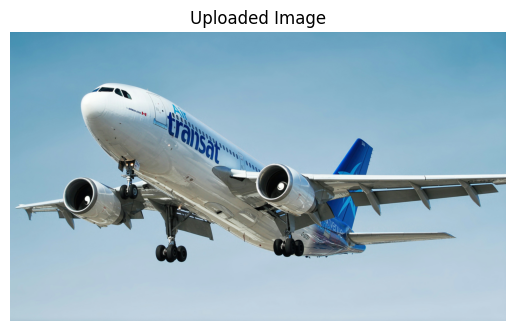

Predicted class: airplane
Confidence: 0.9739684462547302


In [17]:

from PIL import Image

from google.colab import files
uploaded = files.upload()

classes = train_data.classes

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    ),
])

img = Image.open("airplane_image.jpg").convert("RGB")

plt.imshow(img)
plt.axis('off')
plt.title("Uploaded Image")
plt.show()

img_tensor = transform(img).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(img_tensor)
    probs = torch.softmax(output, dim=1)
    pred_idx = probs.argmax(dim=1).item()

print("Predicted class:", classes[pred_idx])
print("Confidence:", probs[0][pred_idx].item())
